# RadarCOVID-Report

## Data Extraction

In [1]:
import datetime
import json
import logging
import os
import shutil
import tempfile
import textwrap
import uuid

import matplotlib.pyplot as plt
import matplotlib.ticker
import numpy as np
import pandas as pd
import retry
import seaborn as sns

%matplotlib inline

In [2]:
current_working_directory = os.environ.get("PWD")
if current_working_directory:
    os.chdir(current_working_directory)

sns.set()
matplotlib.rcParams["figure.figsize"] = (15, 6)

extraction_datetime = datetime.datetime.utcnow()
extraction_date = extraction_datetime.strftime("%Y-%m-%d")
extraction_previous_datetime = extraction_datetime - datetime.timedelta(days=1)
extraction_previous_date = extraction_previous_datetime.strftime("%Y-%m-%d")
extraction_date_with_hour = datetime.datetime.utcnow().strftime("%Y-%m-%d@%H")
current_hour = datetime.datetime.utcnow().hour
are_today_results_partial = current_hour != 23

### Constants

In [3]:
from Modules.ExposureNotification import exposure_notification_io

spain_region_country_code = "ES"
germany_region_country_code = "DE"

default_backend_identifier = spain_region_country_code

backend_generation_days = 7 * 2
daily_summary_days = 7 * 4 * 3
daily_plot_days = 7 * 4
tek_dumps_load_limit = daily_summary_days + 1

default_shared_diagnosis_generation_to_upload_days = 1

### Parameters

In [4]:
environment_backend_identifier = os.environ.get("RADARCOVID_REPORT__BACKEND_IDENTIFIER")
if environment_backend_identifier:
    report_backend_identifier = environment_backend_identifier
else:
    report_backend_identifier = default_backend_identifier
report_backend_identifier

'ES'

In [5]:
efgs_supported_countries_backend_identifier = germany_region_country_code
efgs_supported_countries_backend_client = \
    exposure_notification_io.get_backend_client_with_identifier(
        backend_identifier=efgs_supported_countries_backend_identifier)
efgs_source_regions = efgs_supported_countries_backend_client.get_supported_countries()
if report_backend_identifier in efgs_source_regions:
    default_source_regions = "EFGS"
else:
    default_source_regions = report_backend_identifier.split("-")[0].split("@")[0]

environment_source_regions = os.environ.get("RADARCOVID_REPORT__SOURCE_REGIONS")
if environment_source_regions:
    report_source_regions = environment_source_regions
else:
    report_source_regions = default_source_regions

if report_source_regions == "EFGS":
    if report_backend_identifier in efgs_source_regions:
        efgs_source_regions = \
            [report_backend_identifier] + \
            sorted(list(set(efgs_source_regions).difference([report_backend_identifier])))
    report_source_regions = efgs_source_regions
else:
    report_source_regions = report_source_regions.split(",")

report_source_regions

['ES']

In [6]:
environment_download_only_from_report_backend = \
    os.environ.get("RADARCOVID_REPORT__DOWNLOAD_ONLY_FROM_REPORT_BACKEND")
if environment_download_only_from_report_backend:
    report_backend_identifiers = [report_backend_identifier]
else:
    report_backend_identifiers = None

report_backend_identifiers

In [7]:
environment_shared_diagnosis_generation_to_upload_days = \
    os.environ.get("RADARCOVID_REPORT__SHARED_DIAGNOSIS_GENERATION_TO_UPLOAD_DAYS")
if environment_shared_diagnosis_generation_to_upload_days:
    shared_diagnosis_generation_to_upload_days = \
        int(environment_shared_diagnosis_generation_to_upload_days)
else:
    shared_diagnosis_generation_to_upload_days = \
        default_shared_diagnosis_generation_to_upload_days

shared_diagnosis_generation_to_upload_days

1

### COVID-19 Cases

In [8]:
@retry.retry(tries=10, delay=10, backoff=1.1, jitter=(0, 10))
def download_cases_dataframe_from_ecdc():
    return pd.read_csv(
        "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv/data.csv")

confirmed_df = download_cases_dataframe_from_ecdc()

radar_covid_countries = set(report_source_regions)

confirmed_df = confirmed_df[["dateRep", "cases", "geoId"]]
confirmed_df.rename(
    columns={
        "dateRep":"sample_date",
        "cases": "new_cases",
        "geoId": "country_code",
    },
    inplace=True)
confirmed_df = confirmed_df[confirmed_df.country_code.isin(radar_covid_countries)]
confirmed_df["sample_date"] = pd.to_datetime(confirmed_df.sample_date, dayfirst=True)
confirmed_df = confirmed_df.groupby("sample_date").new_cases.sum().reset_index()
confirmed_df.sort_values("sample_date", inplace=True)
confirmed_df.tail()

,sample_date,new_cases
297,2020-10-23,19851
298,2020-10-24,0
299,2020-10-25,0
300,2020-10-26,52188
301,2020-10-27,18418


In [9]:
confirmed_days = pd.date_range(
    start=confirmed_df.iloc[0].sample_date,
    end=extraction_datetime)
confirmed_days_df = pd.DataFrame(data=confirmed_days, columns=["sample_date"])
confirmed_df = confirmed_days_df.merge(confirmed_df, how="left")
confirmed_df["sample_date"] = confirmed_df.sample_date.dt.strftime("%Y-%m-%d")
confirmed_df.sort_values("sample_date", inplace=True)
confirmed_df.tail()

,sample_date,new_cases
298,2020-10-24,0.0
299,2020-10-25,0.0
300,2020-10-26,52188.0
301,2020-10-27,18418.0
302,2020-10-28,NaN


In [10]:
confirmed_df.columns = ["sample_date_string", "new_cases"]
confirmed_df.sort_values("sample_date_string", inplace=True)
confirmed_df["covid_cases"] = confirmed_df.new_cases.rolling(7).mean().round()
confirmed_df.fillna(method="ffill", inplace=True)
confirmed_df.tail()

,sample_date_string,new_cases,covid_cases
298,2020-10-24,0.0,15653.0
299,2020-10-25,0.0,15653.0
300,2020-10-26,52188.0,17696.0
301,2020-10-27,18418.0,18345.0
302,2020-10-28,18418.0,18345.0


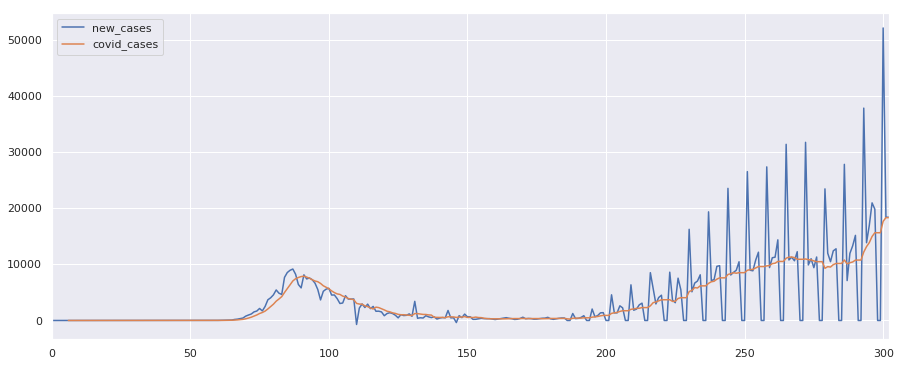

In [11]:
confirmed_df[["new_cases", "covid_cases"]].plot()

### Extract API TEKs

In [12]:
raw_zip_path_prefix = "Data/TEKs/Raw/"
fail_on_error_backend_identifiers = [report_backend_identifier]
multi_backend_exposure_keys_df = \
    exposure_notification_io.download_exposure_keys_from_backends(
        backend_identifiers=report_backend_identifiers,
        generation_days=backend_generation_days,
        fail_on_error_backend_identifiers=fail_on_error_backend_identifiers,
        save_raw_zip_path_prefix=raw_zip_path_prefix)
multi_backend_exposure_keys_df["region"] = multi_backend_exposure_keys_df["backend_identifier"]
multi_backend_exposure_keys_df.rename(
    columns={
        "generation_datetime": "sample_datetime",
        "generation_date_string": "sample_date_string",
    },
    inplace=True)
multi_backend_exposure_keys_df.head()

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 102, in download_exposure_keys_from_backends
    backend_exposure_keys_df = backend_client.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 40, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/corona_warn_app.py", line 25, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://svc90.main.px.t-online.de/

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 102, in download_exposure_keys_from_backends
    backend_exposure_keys_df = backend_client.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 40, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/corona_warn_app.py", line 25, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://svc90.main.px.t-online.de/

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 102, in download_exposure_keys_from_backends
    backend_exposure_keys_df = backend_client.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 40, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/corona_warn_app.py", line 25, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://svc90.main.px.t-online.de/

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 102, in download_exposure_keys_from_backends
    backend_exposure_keys_df = backend_client.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 40, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/immuni.py", line 27, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://get.immuni.gov.it/v1/keys/eu/ES/ind

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 102, in download_exposure_keys_from_backends
    backend_exposure_keys_df = backend_client.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 40, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/immuni.py", line 27, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://get.immuni.gov.it/v1/keys/eu/IE/ind

Traceback (most recent call last):
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/exposure_notification_io.py", line 102, in download_exposure_keys_from_backends
    backend_exposure_keys_df = backend_client.download_exposure_keys_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/base.py", line 40, in download_exposure_keys_with_parameters
    self.generate_exposure_keys_export_endpoints_with_parameters(**kwargs)
  File "/home/runner/work/Radar-STATS/Radar-STATS/Modules/ExposureNotification/Backends/immuni.py", line 27, in generate_exposure_keys_export_endpoints_with_parameters
    response.raise_for_status()
  File "/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/requests/models.py", line 941, in raise_for_status
    raise HTTPError(http_error_msg, response=self)
requests.exceptions.HTTPError: 404 Client Error: Not Found for url: https://get.immuni.gov.it/v1/keys/eu/DE/ind

,sample_datetime,sample_date_string,region,verification_key_version,verification_key_id,signature_algorithm,key_data,rolling_start_interval_number,rolling_period,transmission_risk_level,backend_identifier
0,2020-10-28,2020-10-28,ES,V1,214,1.2.840.10045.4.3.2,e9716217-4bd0-69f7-4c5c-2153c6cf13c0,2673072,132,0,ES
1,2020-10-28,2020-10-28,ES,V1,214,1.2.840.10045.4.3.2,fb0a4597-dd5e-608a-9b14-df7c846f859a,2673072,130,0,ES
2,2020-10-28,2020-10-28,ES,V1,214,1.2.840.10045.4.3.2,8b7751bd-342f-f689-f4a3-c7f9ab15f2a5,2673072,129,0,ES
3,2020-10-28,2020-10-28,ES,V1,214,1.2.840.10045.4.3.2,a96a3204-e238-4cf6-be35-165799e4acc5,2673072,129,0,ES
4,2020-10-28,2020-10-28,ES,V1,214,1.2.840.10045.4.3.2,fab47f20-c6a3-47cc-ec8c-0fcba2e0c3e6,2673072,129,0,ES


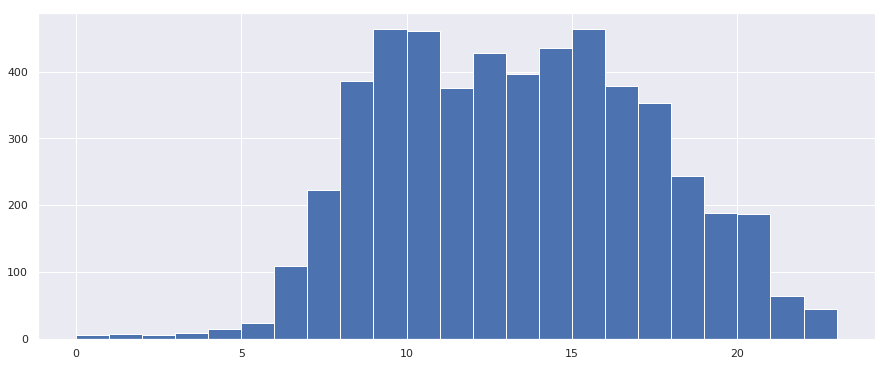

In [13]:
early_teks_df = multi_backend_exposure_keys_df[
    multi_backend_exposure_keys_df.rolling_period < 144].copy()
early_teks_df["rolling_period_in_hours"] = early_teks_df.rolling_period / 6
early_teks_df[early_teks_df.sample_date_string != extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

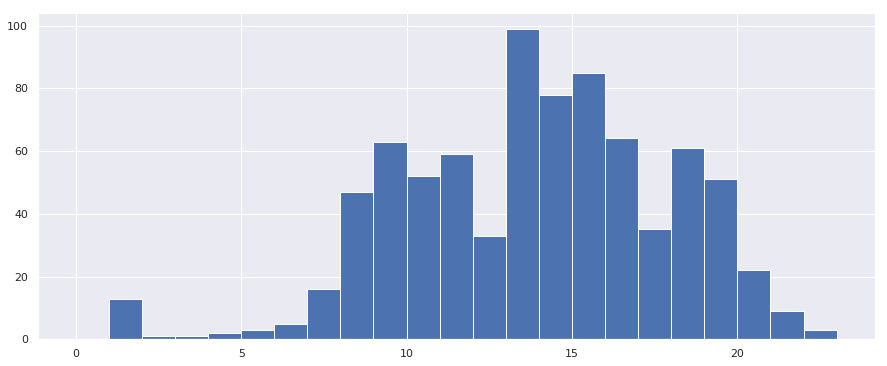

In [14]:
early_teks_df[early_teks_df.sample_date_string == extraction_date] \
    .rolling_period_in_hours.hist(bins=list(range(24)))

In [15]:
multi_backend_exposure_keys_df = multi_backend_exposure_keys_df[[
    "sample_date_string", "region", "key_data"]]
multi_backend_exposure_keys_df.head()

,sample_date_string,region,key_data
0,2020-10-28,ES,e9716217-4bd0-69f7-4c5c-2153c6cf13c0
1,2020-10-28,ES,fb0a4597-dd5e-608a-9b14-df7c846f859a
2,2020-10-28,ES,8b7751bd-342f-f689-f4a3-c7f9ab15f2a5
3,2020-10-28,ES,a96a3204-e238-4cf6-be35-165799e4acc5
4,2020-10-28,ES,fab47f20-c6a3-47cc-ec8c-0fcba2e0c3e6


In [16]:
active_regions = \
    multi_backend_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
active_regions

['EE', 'BE@TST', 'MT', 'PT', 'ES@PRE', 'ES', 'DK', 'BE', 'CH', 'IT', 'DE']

In [17]:
multi_backend_summary_df = multi_backend_exposure_keys_df.groupby(
    ["sample_date_string", "region"]).key_data.nunique().reset_index() \
    .pivot(index="sample_date_string", columns="region") \
    .sort_index(ascending=False)
multi_backend_summary_df.rename(
    columns={"key_data": "shared_teks_by_generation_date"},
    inplace=True)
multi_backend_summary_df.rename_axis("sample_date", inplace=True)
multi_backend_summary_df = multi_backend_summary_df.fillna(0).astype(int)
multi_backend_summary_df = multi_backend_summary_df.head(backend_generation_days)
multi_backend_summary_df.head()

shared_teks_by_generation_date                                   \
region                                  BE BE@TST    CH    DE   DK  EE   ES   
sample_date                                                                   
2020-10-28                               0      0   382     0    0   0  406   
2020-10-27                               0      0  1393     0  191   8  593   
2020-10-26                             504     43  2342  1896  262  15  730   
2020-10-25                             763     45  3140  3179  375  15  776   
2020-10-24                            1111     53  3822  4043  513  16  753   

                                    
region      ES@PRE    IT   MT   PT  
sample_date                         
2020-10-28      14     0    0    0  
2020-10-27     217  1914  109   97  
2020-10-26     472  3681  115  160  
2020-10-25     627  4789  118  207  
2020-10-24     647  5580  122  238

In [18]:
def compute_keys_cross_sharing(x):
    teks_x = x.key_data_x.item()
    common_teks = set(teks_x).intersection(x.key_data_y.item())
    common_teks_fraction = len(common_teks) / len(teks_x)
    return pd.Series(dict(
        common_teks=common_teks,
        common_teks_fraction=common_teks_fraction,
    ))

multi_backend_exposure_keys_by_region_df = \
    multi_backend_exposure_keys_df.groupby("region").key_data.unique().reset_index()
multi_backend_exposure_keys_by_region_df["_merge"] = True
multi_backend_exposure_keys_by_region_combination_df = \
    multi_backend_exposure_keys_by_region_df.merge(
        multi_backend_exposure_keys_by_region_df, on="_merge")
multi_backend_exposure_keys_by_region_combination_df.drop(
    columns=["_merge"], inplace=True)
if multi_backend_exposure_keys_by_region_combination_df.region_x.nunique() > 1:
    multi_backend_exposure_keys_by_region_combination_df = \
        multi_backend_exposure_keys_by_region_combination_df[
            multi_backend_exposure_keys_by_region_combination_df.region_x !=
            multi_backend_exposure_keys_by_region_combination_df.region_y]
multi_backend_exposure_keys_cross_sharing_df = \
    multi_backend_exposure_keys_by_region_combination_df \
        .groupby(["region_x", "region_y"]) \
        .apply(compute_keys_cross_sharing) \
        .reset_index()
multi_backend_cross_sharing_summary_df = \
    multi_backend_exposure_keys_cross_sharing_df.pivot_table(
        values=["common_teks_fraction"],
        columns="region_x",
        index="region_y",
        aggfunc=lambda x: x.item())
multi_backend_cross_sharing_summary_df

<ipython-input-18-4e21708c19d8>:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  teks_x = x.key_data_x.item()
<ipython-input-18-4e21708c19d8>:3: FutureWarning: `item` has been deprecated and will be removed in a future version
  common_teks = set(teks_x).intersection(x.key_data_y.item())


<ipython-input-18-4e21708c19d8>:33: FutureWarning: `item` has been deprecated and will be removed in a future version
  aggfunc=lambda x: x.item())


common_teks_fraction                                                 \
region_x                   BE BE@TST   CH        DE   DK   EE   ES    ES@PRE   
region_y                                                                       
BE                        NaN    0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
BE@TST                    0.0    NaN  0.0  0.000000  0.0  0.0  0.0  0.000000   
CH                        0.0    0.0  NaN  0.000000  0.0  0.0  0.0  0.000000   
DE                        0.0    0.0  0.0       NaN  0.0  0.0  0.0  0.000000   
DK                        0.0    0.0  0.0  0.000000  NaN  0.0  0.0  0.000000   
EE                        0.0    0.0  0.0  0.000000  0.0  NaN  0.0  0.000000   
ES                        0.0    0.0  0.0  0.000000  0.0  0.0  NaN  0.000000   
ES@PRE                    0.0    0.0  0.0  0.000000  0.0  0.0  0.0       NaN   
IT                        0.0    0.0  0.0  0.664979  0.0  0.0  0.0  0.010884   
MT                        0.0    0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   
PT                        0.0    0.0  0.0  0.000000  0.0  0.0  0.0  0.000000   

                              
region_x        IT   MT   PT  
region_y                      
BE        0.000000  0.0  0.0  
BE@TST    0.000000  0.0  0.0  
CH        0.000000  0.0  0.0  
DE        0.720302  0.0  0.0  
DK        0.000000  0.0  0.0  
EE        0.000000  0.0  0.0  
ES        0.000000  0.0  0.0  
ES@PRE    0.001159  0.0  0.0  
IT             NaN  0.0  0.0  
MT        0.000000  NaN  0.0  
PT        0.000000  0.0  NaN

In [19]:
multi_backend_without_active_region_exposure_keys_df = \
    multi_backend_exposure_keys_df[multi_backend_exposure_keys_df.region != report_backend_identifier]
multi_backend_without_active_region = \
    multi_backend_without_active_region_exposure_keys_df.groupby("region").key_data.nunique().sort_values().index.unique().tolist()
multi_backend_without_active_region

['EE', 'BE@TST', 'MT', 'PT', 'ES@PRE', 'DK', 'BE', 'CH', 'IT', 'DE']

In [20]:
exposure_keys_summary_df = multi_backend_exposure_keys_df[
    multi_backend_exposure_keys_df.region == report_backend_identifier]
exposure_keys_summary_df.drop(columns=["region"], inplace=True)
exposure_keys_summary_df = \
    exposure_keys_summary_df.groupby(["sample_date_string"]).key_data.nunique().to_frame()
exposure_keys_summary_df = \
    exposure_keys_summary_df.reset_index().set_index("sample_date_string")
exposure_keys_summary_df.sort_index(ascending=False, inplace=True)
exposure_keys_summary_df.rename(columns={"key_data": "shared_teks_by_generation_date"}, inplace=True)
exposure_keys_summary_df.head()

/opt/hostedtoolcache/Python/3.8.6/x64/lib/python3.8/site-packages/pandas/core/frame.py:4110: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


,shared_teks_by_generation_date
sample_date_string,
2020-10-28,406
2020-10-27,593
2020-10-26,730
2020-10-25,776
2020-10-24,753


### Dump API TEKs

In [21]:
tek_list_df = multi_backend_exposure_keys_df[
    ["sample_date_string", "region", "key_data"]].copy()
tek_list_df["key_data"] = tek_list_df["key_data"].apply(str)
tek_list_df.rename(columns={
    "sample_date_string": "sample_date",
    "key_data": "tek_list"}, inplace=True)
tek_list_df = tek_list_df.groupby(
    ["sample_date", "region"]).tek_list.unique().reset_index()
tek_list_df["extraction_date"] = extraction_date
tek_list_df["extraction_date_with_hour"] = extraction_date_with_hour

tek_list_path_prefix = "Data/TEKs/"
tek_list_current_path = tek_list_path_prefix + f"/Current/RadarCOVID-TEKs.json"
tek_list_daily_path = tek_list_path_prefix + f"Daily/RadarCOVID-TEKs-{extraction_date}.json"
tek_list_hourly_path = tek_list_path_prefix + f"Hourly/RadarCOVID-TEKs-{extraction_date_with_hour}.json"

for path in [tek_list_current_path, tek_list_daily_path, tek_list_hourly_path]:
    os.makedirs(os.path.dirname(path), exist_ok=True)

tek_list_df.drop(columns=["extraction_date", "extraction_date_with_hour"]).to_json(
    tek_list_current_path,
    lines=True, orient="records")
tek_list_df.drop(columns=["extraction_date_with_hour"]).to_json(
    tek_list_daily_path,
    lines=True, orient="records")
tek_list_df.to_json(
    tek_list_hourly_path,
    lines=True, orient="records")
tek_list_df.head()

,sample_date,region,tek_list,extraction_date,extraction_date_with_hour
0,2020-10-15,BE,"[00446a40-b724-37b9-e612-e78d0fb7d843, 004eb51...",2020-10-28,2020-10-28@23
1,2020-10-15,BE@TST,"[0b6be368-a2a8-12cc-4a1e-4eca6429a2bd, 0bf1cfc...",2020-10-28,2020-10-28@23
2,2020-10-15,CH,"[5f9169c7-77bd-ccb3-3b68-848a6c40d1dc, d947ac4...",2020-10-28,2020-10-28@23
3,2020-10-15,DE,"[000659c3-e694-a022-b2be-1203d679a64d, 0035c7c...",2020-10-28,2020-10-28@23
4,2020-10-15,DK,"[e13cb8c9-fe70-92d3-324d-67a8b69337ef, 28ca200...",2020-10-28,2020-10-28@23


### Load TEK Dumps

In [22]:
import glob

def load_extracted_teks(mode, region=None, limit=None) -> pd.DataFrame:
    extracted_teks_df = pd.DataFrame(columns=["region"])
    file_paths = list(reversed(sorted(glob.glob(tek_list_path_prefix + mode + "/RadarCOVID-TEKs-*.json"))))
    if limit:
        file_paths = file_paths[:limit]
    for file_path in file_paths:
        logging.info(f"Loading TEKs from '{file_path}'...")
        iteration_extracted_teks_df = pd.read_json(file_path, lines=True)
        extracted_teks_df = extracted_teks_df.append(
            iteration_extracted_teks_df, sort=False)
    extracted_teks_df["region"] = \
        extracted_teks_df.region.fillna(spain_region_country_code).copy()
    if region:
        extracted_teks_df = \
            extracted_teks_df[extracted_teks_df.region == region]
    return extracted_teks_df

In [23]:
daily_extracted_teks_df = load_extracted_teks(
    mode="Daily",
    region=report_backend_identifier,
    limit=tek_dumps_load_limit)
daily_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
6,ES,2020-10-15,"[5ab72463-fcef-c19f-0b08-c88fdd7270df, 15af511...",2020-10-28,NaN
17,ES,2020-10-16,"[eb757fcd-7057-5459-71ff-7163c763725a, 92a176f...",2020-10-28,NaN
28,ES,2020-10-17,"[6e674191-e5e6-ed3a-a9e3-176bb5c929e9, dd0dc97...",2020-10-28,NaN
39,ES,2020-10-18,"[ecd175ab-f23b-55fe-a18a-72f9c73dd210, 19e6918...",2020-10-28,NaN
50,ES,2020-10-19,"[eb7227a4-ce14-b30b-b922-8fc81996577f, 3f21c46...",2020-10-28,NaN


In [24]:
exposure_keys_summary_df_ = daily_extracted_teks_df \
    .sort_values("extraction_date", ascending=False) \
    .groupby("sample_date").tek_list.first() \
    .to_frame()
exposure_keys_summary_df_.index.name = "sample_date_string"
exposure_keys_summary_df_["tek_list"] = \
    exposure_keys_summary_df_.tek_list.apply(len)
exposure_keys_summary_df_ = exposure_keys_summary_df_ \
    .rename(columns={"tek_list": "shared_teks_by_generation_date"}) \
    .sort_index(ascending=False)
exposure_keys_summary_df = exposure_keys_summary_df_
exposure_keys_summary_df.head()

,shared_teks_by_generation_date
sample_date_string,
2020-10-28,406
2020-10-27,593
2020-10-26,730
2020-10-25,776
2020-10-24,753


### Daily New TEKs

In [25]:
tek_list_df = daily_extracted_teks_df.groupby("extraction_date").tek_list.apply(
    lambda x: set(sum(x, []))).reset_index()
tek_list_df = tek_list_df.set_index("extraction_date").sort_index(ascending=True)
tek_list_df.head()

,tek_list
extraction_date,
2020-08-29,"{4b427ea1-6d5f-43cd-cdc0-e7b6f6b11939, be424ae..."
2020-08-30,"{4b427ea1-6d5f-43cd-cdc0-e7b6f6b11939, be424ae..."
2020-08-31,"{4b427ea1-6d5f-43cd-cdc0-e7b6f6b11939, be424ae..."
2020-09-01,"{4b427ea1-6d5f-43cd-cdc0-e7b6f6b11939, be424ae..."
2020-09-02,"{4b427ea1-6d5f-43cd-cdc0-e7b6f6b11939, be424ae..."


In [26]:
def compute_teks_by_generation_and_upload_date(date):
    day_new_teks_set_df = tek_list_df.copy().diff()
    try:
        day_new_teks_set = day_new_teks_set_df[
            day_new_teks_set_df.index == date].tek_list.item()
    except ValueError:
        day_new_teks_set = None
    if pd.isna(day_new_teks_set):
        day_new_teks_set = set()
    day_new_teks_df = daily_extracted_teks_df[
        daily_extracted_teks_df.extraction_date == date].copy()
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.tek_list.apply(lambda x: set(x).intersection(day_new_teks_set))
    day_new_teks_df["shared_teks"] = \
        day_new_teks_df.shared_teks.apply(len)
    day_new_teks_df["upload_date"] = date
    day_new_teks_df.rename(columns={"sample_date": "generation_date"}, inplace=True)
    day_new_teks_df = day_new_teks_df[
        ["upload_date", "generation_date", "shared_teks"]]
    day_new_teks_df["generation_to_upload_days"] = \
        (pd.to_datetime(day_new_teks_df.upload_date) -
         pd.to_datetime(day_new_teks_df.generation_date)).dt.days
    day_new_teks_df = day_new_teks_df[day_new_teks_df.shared_teks > 0]
    return day_new_teks_df

shared_teks_generation_to_upload_df = pd.DataFrame()
for upload_date in daily_extracted_teks_df.extraction_date.unique():
    shared_teks_generation_to_upload_df = \
        shared_teks_generation_to_upload_df.append(
            compute_teks_by_generation_and_upload_date(date=upload_date))
shared_teks_generation_to_upload_df \
    .sort_values(["upload_date", "generation_date"], ascending=False, inplace=True)
shared_teks_generation_to_upload_df.tail()

<ipython-input-26-827222b35590>:4: FutureWarning: `item` has been deprecated and will be removed in a future version
  day_new_teks_set = day_new_teks_set_df[


,upload_date,generation_date,shared_teks,generation_to_upload_days
10,2020-08-30,2020-08-29,16,1
9,2020-08-30,2020-08-28,5,2
8,2020-08-30,2020-08-27,3,3
7,2020-08-30,2020-08-26,3,4
6,2020-08-30,2020-08-25,2,5


In [27]:
today_new_teks_df = \
    shared_teks_generation_to_upload_df[
        shared_teks_generation_to_upload_df.upload_date == extraction_date].copy()
today_new_teks_df.tail()

,upload_date,generation_date,shared_teks,generation_to_upload_days
50,2020-10-28,2020-10-19,17,9
39,2020-10-28,2020-10-18,10,10
28,2020-10-28,2020-10-17,7,11
17,2020-10-28,2020-10-16,7,12
6,2020-10-28,2020-10-15,6,13


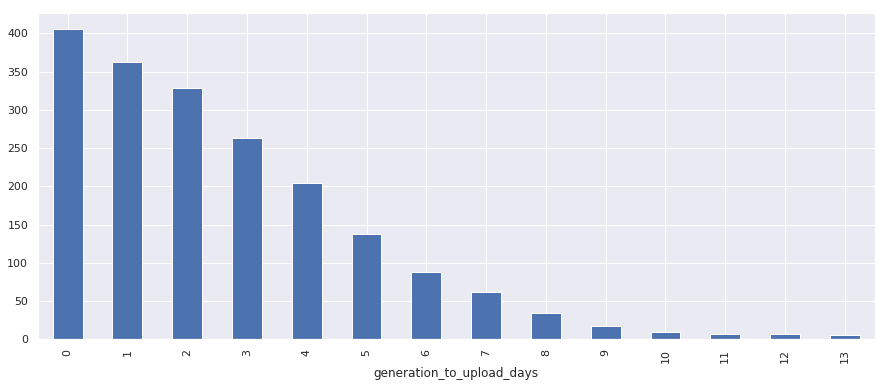

In [28]:
if not today_new_teks_df.empty:
    today_new_teks_df.set_index("generation_to_upload_days") \
        .sort_index().shared_teks.plot.bar()

In [29]:
generation_to_upload_period_pivot_df = \
    shared_teks_generation_to_upload_df[
        ["upload_date", "generation_to_upload_days", "shared_teks"]] \
        .pivot(index="upload_date", columns="generation_to_upload_days") \
        .sort_index(ascending=False).fillna(0).astype(int) \
        .droplevel(level=0, axis=1)
generation_to_upload_period_pivot_df.head()

generation_to_upload_days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
upload_date,,,,,,,,,,,,,,
2020-10-28,406,362,328,263,204,138,88,62,35,17,10,7,7,6
2020-10-27,231,187,164,123,98,77,44,28,22,11,3,0,0,0
2020-10-26,215,170,145,124,105,85,51,32,24,18,12,6,5,2
2020-10-25,179,104,95,82,71,55,37,25,15,8,5,2,1,0
2020-10-24,177,125,106,89,69,50,28,19,12,10,6,5,5,2


In [30]:
new_tek_df = tek_list_df.diff().tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else None).to_frame().reset_index()
new_tek_df.rename(columns={
    "tek_list": "shared_teks_by_upload_date",
    "extraction_date": "sample_date_string",}, inplace=True)
new_tek_df.tail()

,sample_date_string,shared_teks_by_upload_date
56,2020-10-24,703.0
57,2020-10-25,679.0
58,2020-10-26,994.0
59,2020-10-27,988.0
60,2020-10-28,1933.0


In [31]:
estimated_shared_diagnoses_df = daily_extracted_teks_df.copy()
estimated_shared_diagnoses_df["new_sample_extraction_date"] = \
    pd.to_datetime(estimated_shared_diagnoses_df.sample_date) + \
    datetime.timedelta(shared_diagnosis_generation_to_upload_days)
estimated_shared_diagnoses_df["extraction_date"] = pd.to_datetime(estimated_shared_diagnoses_df.extraction_date)
estimated_shared_diagnoses_df["sample_date"] = pd.to_datetime(estimated_shared_diagnoses_df.sample_date)
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour,new_sample_extraction_date
6,ES,2020-10-15,"[5ab72463-fcef-c19f-0b08-c88fdd7270df, 15af511...",2020-10-28,NaN,2020-10-16
17,ES,2020-10-16,"[eb757fcd-7057-5459-71ff-7163c763725a, 92a176f...",2020-10-28,NaN,2020-10-17
28,ES,2020-10-17,"[6e674191-e5e6-ed3a-a9e3-176bb5c929e9, dd0dc97...",2020-10-28,NaN,2020-10-18
39,ES,2020-10-18,"[ecd175ab-f23b-55fe-a18a-72f9c73dd210, 19e6918...",2020-10-28,NaN,2020-10-19
50,ES,2020-10-19,"[eb7227a4-ce14-b30b-b922-8fc81996577f, 3f21c46...",2020-10-28,NaN,2020-10-20


In [32]:
# Sometimes TEKs from the same day are uploaded, we do not count them as new TEK devices:
same_day_tek_list_df = estimated_shared_diagnoses_df[
    estimated_shared_diagnoses_df.sample_date == estimated_shared_diagnoses_df.extraction_date].copy()
same_day_tek_list_df = same_day_tek_list_df[["extraction_date", "tek_list"]].rename(
    columns={"tek_list": "same_day_tek_list"})
same_day_tek_list_df.head()

,extraction_date,same_day_tek_list
141,2020-10-28,"[e9716217-4bd0-69f7-4c5c-2153c6cf13c0, fb0a459..."
141,2020-10-27,"[3c782e70-e92a-5c64-9bce-caf3cb788627, bebe0fb..."
140,2020-10-26,"[bf91925c-265d-faff-820f-069c8d6d1b20, f12d517..."
128,2020-10-25,"[6531e43f-d46f-7387-27d9-9cc0228e6fa8, 3e0fad2..."
128,2020-10-24,"[98c7e64d-c2ca-6272-3114-84c70734315d, 663f955..."


In [33]:
shared_teks_uploaded_on_generation_date_df = same_day_tek_list_df.rename(
    columns={
        "extraction_date": "sample_date_string",
        "same_day_tek_list": "shared_teks_uploaded_on_generation_date",
    })
shared_teks_uploaded_on_generation_date_df.shared_teks_uploaded_on_generation_date = \
 shared_teks_uploaded_on_generation_date_df.shared_teks_uploaded_on_generation_date.apply(len)
shared_teks_uploaded_on_generation_date_df.head()
shared_teks_uploaded_on_generation_date_df["sample_date_string"] = \
    shared_teks_uploaded_on_generation_date_df.sample_date_string.dt.strftime("%Y-%m-%d")
shared_teks_uploaded_on_generation_date_df.head()

,sample_date_string,shared_teks_uploaded_on_generation_date
141,2020-10-28,406
141,2020-10-27,231
140,2020-10-26,215
128,2020-10-25,179
128,2020-10-24,177


In [34]:
estimated_shared_diagnoses_df = estimated_shared_diagnoses_df[
    estimated_shared_diagnoses_df.new_sample_extraction_date == estimated_shared_diagnoses_df.extraction_date]
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour,new_sample_extraction_date
135,ES,2020-10-27,"[266df5f0-1256-5a8b-ecd7-2243716dd85d, 54ab10e...",2020-10-28,NaN,2020-10-28
135,ES,2020-10-26,"[fd724c86-1bb1-2535-c153-2ac47a476d06, edff8db...",2020-10-27,NaN,2020-10-27
134,ES,2020-10-25,"[35911789-8ea1-60dd-1785-ddc4fa3d0adb, 562e172...",2020-10-26,NaN,2020-10-26
122,ES,2020-10-24,"[d51284c8-56c5-b485-690b-a4f8d4dd2275, 9162aae...",2020-10-25,NaN,2020-10-25
122,ES,2020-10-23,"[c3d59eb7-01f2-ad63-af9d-1ba1f017f356, 110b8d6...",2020-10-24,NaN,2020-10-24


In [35]:
same_day_tek_list_df["extraction_date"] = \
    same_day_tek_list_df.extraction_date + datetime.timedelta(1)
estimated_shared_diagnoses_df = \
    estimated_shared_diagnoses_df.merge(same_day_tek_list_df, how="left", on=["extraction_date"])
estimated_shared_diagnoses_df["same_day_tek_list"] = \
    estimated_shared_diagnoses_df.same_day_tek_list.apply(lambda x: [] if x is np.nan else x)
estimated_shared_diagnoses_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour,new_sample_extraction_date,same_day_tek_list
0,ES,2020-10-27,"[266df5f0-1256-5a8b-ecd7-2243716dd85d, 54ab10e...",2020-10-28,NaN,2020-10-28,"[3c782e70-e92a-5c64-9bce-caf3cb788627, bebe0fb..."
1,ES,2020-10-26,"[fd724c86-1bb1-2535-c153-2ac47a476d06, edff8db...",2020-10-27,NaN,2020-10-27,"[bf91925c-265d-faff-820f-069c8d6d1b20, f12d517..."
2,ES,2020-10-25,"[35911789-8ea1-60dd-1785-ddc4fa3d0adb, 562e172...",2020-10-26,NaN,2020-10-26,"[6531e43f-d46f-7387-27d9-9cc0228e6fa8, 3e0fad2..."
3,ES,2020-10-24,"[d51284c8-56c5-b485-690b-a4f8d4dd2275, 9162aae...",2020-10-25,NaN,2020-10-25,"[98c7e64d-c2ca-6272-3114-84c70734315d, 663f955..."
4,ES,2020-10-23,"[c3d59eb7-01f2-ad63-af9d-1ba1f017f356, 110b8d6...",2020-10-24,NaN,2020-10-24,"[c183bc1b-ab2d-b3e1-593a-25aa1a70be72, decd21d..."


In [36]:
estimated_shared_diagnoses_df.set_index("extraction_date", inplace=True)
if estimated_shared_diagnoses_df.empty:
    estimated_shared_diagnoses_df["shared_diagnoses"] = 0
else:
    estimated_shared_diagnoses_df["shared_diagnoses"] = estimated_shared_diagnoses_df.apply(
        lambda x: len(set(x.tek_list).difference(x.same_day_tek_list)), axis=1).copy()
estimated_shared_diagnoses_df.reset_index(inplace=True)
estimated_shared_diagnoses_df.rename(columns={
    "extraction_date": "sample_date_string"}, inplace=True)
estimated_shared_diagnoses_df = estimated_shared_diagnoses_df[["sample_date_string", "shared_diagnoses"]]
if not estimated_shared_diagnoses_df.empty:
    estimated_shared_diagnoses_df["sample_date_string"] = \
        estimated_shared_diagnoses_df.sample_date_string.dt.strftime("%Y-%m-%d")
estimated_shared_diagnoses_df.head()

,sample_date_string,shared_diagnoses
0,2020-10-28,362
1,2020-10-27,187
2,2020-10-26,170
3,2020-10-25,104
4,2020-10-24,125


### Hourly New TEKs

In [37]:
hourly_extracted_teks_df = load_extracted_teks(
    mode="Hourly", region=report_backend_identifier, limit=25)
hourly_extracted_teks_df.head()

,region,sample_date,tek_list,extraction_date,extraction_date_with_hour
6,ES,2020-10-15,"[5ab72463-fcef-c19f-0b08-c88fdd7270df, 15af511...",2020-10-28,2020-10-28@23
17,ES,2020-10-16,"[eb757fcd-7057-5459-71ff-7163c763725a, 92a176f...",2020-10-28,2020-10-28@23
28,ES,2020-10-17,"[6e674191-e5e6-ed3a-a9e3-176bb5c929e9, dd0dc97...",2020-10-28,2020-10-28@23
39,ES,2020-10-18,"[ecd175ab-f23b-55fe-a18a-72f9c73dd210, 19e6918...",2020-10-28,2020-10-28@23
50,ES,2020-10-19,"[eb7227a4-ce14-b30b-b922-8fc81996577f, 3f21c46...",2020-10-28,2020-10-28@23


In [38]:
hourly_new_tek_count_df = hourly_extracted_teks_df \
    .groupby("extraction_date_with_hour").tek_list. \
    apply(lambda x: set(sum(x, []))).reset_index().copy()
hourly_new_tek_count_df = hourly_new_tek_count_df.set_index("extraction_date_with_hour") \
    .sort_index(ascending=True)

hourly_new_tek_count_df["new_tek_list"] = hourly_new_tek_count_df.tek_list.diff()
hourly_new_tek_count_df["new_tek_count"] = hourly_new_tek_count_df.new_tek_list.apply(
    lambda x: len(x) if not pd.isna(x) else 0)
hourly_new_tek_count_df.rename(columns={
    "new_tek_count": "shared_teks_by_upload_date"}, inplace=True)
hourly_new_tek_count_df = hourly_new_tek_count_df.reset_index()[[
    "extraction_date_with_hour", "shared_teks_by_upload_date"]]
hourly_new_tek_count_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date
0,2020-10-27@22,0
1,2020-10-27@23,0
2,2020-10-28@01,27
3,2020-10-28@02,15
4,2020-10-28@03,0


In [39]:
hourly_estimated_shared_diagnoses_df = hourly_extracted_teks_df.copy()
hourly_estimated_shared_diagnoses_df["new_sample_extraction_date"] = \
    pd.to_datetime(hourly_estimated_shared_diagnoses_df.sample_date) + \
    datetime.timedelta(shared_diagnosis_generation_to_upload_days)
hourly_estimated_shared_diagnoses_df["extraction_date"] = \
    pd.to_datetime(hourly_estimated_shared_diagnoses_df.extraction_date)

hourly_estimated_shared_diagnoses_df = hourly_estimated_shared_diagnoses_df[
    hourly_estimated_shared_diagnoses_df.new_sample_extraction_date ==
    hourly_estimated_shared_diagnoses_df.extraction_date]
hourly_estimated_shared_diagnoses_df = \
    hourly_estimated_shared_diagnoses_df.merge(same_day_tek_list_df, how="left", on=["extraction_date"])
hourly_estimated_shared_diagnoses_df["same_day_tek_list"] = \
    hourly_estimated_shared_diagnoses_df.same_day_tek_list.apply(lambda x: [] if x is np.nan else x)

if hourly_estimated_shared_diagnoses_df.empty:
    hourly_estimated_shared_diagnoses_df["shared_diagnoses"] = 0
else:
    hourly_estimated_shared_diagnoses_df["shared_diagnoses"] = \
        hourly_estimated_shared_diagnoses_df.apply(
            lambda x: len(set(x.tek_list).difference(x.same_day_tek_list)), axis=1)
hourly_estimated_shared_diagnoses_df = \
    hourly_estimated_shared_diagnoses_df.sort_values("extraction_date_with_hour").copy()
hourly_estimated_shared_diagnoses_df["shared_diagnoses"] = hourly_estimated_shared_diagnoses_df \
    .groupby("extraction_date").shared_diagnoses.diff() \
    .fillna(0).astype(int)

hourly_estimated_shared_diagnoses_df.set_index("extraction_date_with_hour", inplace=True)
hourly_estimated_shared_diagnoses_df.reset_index(inplace=True)
hourly_estimated_shared_diagnoses_df = hourly_estimated_shared_diagnoses_df[[
    "extraction_date_with_hour", "shared_diagnoses"]]
hourly_estimated_shared_diagnoses_df.head()

,extraction_date_with_hour,shared_diagnoses
0,2020-10-27@22,0
1,2020-10-27@23,0
2,2020-10-28@01,0
3,2020-10-28@02,10
4,2020-10-28@03,0


In [40]:
hourly_summary_df = hourly_new_tek_count_df.merge(
    hourly_estimated_shared_diagnoses_df, on=["extraction_date_with_hour"], how="outer")
hourly_summary_df.set_index("extraction_date_with_hour", inplace=True)
hourly_summary_df = hourly_summary_df.fillna(0).astype(int).reset_index()
hourly_summary_df["datetime_utc"] = pd.to_datetime(
    hourly_summary_df.extraction_date_with_hour, format="%Y-%m-%d@%H")
hourly_summary_df.set_index("datetime_utc", inplace=True)
hourly_summary_df = hourly_summary_df.tail(-1)
hourly_summary_df.head()

,extraction_date_with_hour,shared_teks_by_upload_date,shared_diagnoses
datetime_utc,,,
2020-10-27 23:00:00,2020-10-27@23,0,0
2020-10-28 01:00:00,2020-10-28@01,27,0
2020-10-28 02:00:00,2020-10-28@02,15,10
2020-10-28 03:00:00,2020-10-28@03,0,0
2020-10-28 04:00:00,2020-10-28@04,6,1


### Data Merge

In [41]:
result_summary_df = exposure_keys_summary_df.merge(
    new_tek_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date
0,2020-10-28,406,1933.0
1,2020-10-27,593,988.0
2,2020-10-26,730,994.0
3,2020-10-25,776,679.0
4,2020-10-24,753,703.0


In [42]:
result_summary_df = result_summary_df.merge(
    shared_teks_uploaded_on_generation_date_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date
0,2020-10-28,406,1933.0,406.0
1,2020-10-27,593,988.0,231.0
2,2020-10-26,730,994.0,215.0
3,2020-10-25,776,679.0,179.0
4,2020-10-24,753,703.0,177.0


In [43]:
result_summary_df = result_summary_df.merge(
    estimated_shared_diagnoses_df, on=["sample_date_string"], how="outer")
result_summary_df.head()

,sample_date_string,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-10-28,406,1933.0,406.0,362.0
1,2020-10-27,593,988.0,231.0,187.0
2,2020-10-26,730,994.0,215.0,170.0
3,2020-10-25,776,679.0,179.0,104.0
4,2020-10-24,753,703.0,177.0,125.0


In [44]:
result_summary_df = confirmed_df.tail(daily_summary_days).merge(
    result_summary_df, on=["sample_date_string"], how="left")
result_summary_df.head()

,sample_date_string,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
0,2020-08-06,4088.0,3489.0,NaN,NaN,NaN,NaN
1,2020-08-07,4507.0,3691.0,NaN,NaN,NaN,NaN
2,2020-08-08,0.0,3691.0,NaN,NaN,NaN,NaN
3,2020-08-09,0.0,3691.0,NaN,NaN,NaN,NaN
4,2020-08-10,8618.0,3704.0,NaN,NaN,NaN,NaN


In [45]:
result_summary_df["sample_date"] = pd.to_datetime(result_summary_df.sample_date_string)
result_summary_df.set_index("sample_date", inplace=True)
result_summary_df.drop(columns=["sample_date_string"], inplace=True)
result_summary_df.sort_index(ascending=False, inplace=True)
result_summary_df.head()

,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses
sample_date,,,,,,
2020-10-28,18418.0,18345.0,406.0,1933.0,406.0,362.0
2020-10-27,18418.0,18345.0,593.0,988.0,231.0,187.0
2020-10-26,52188.0,17696.0,730.0,994.0,215.0,170.0
2020-10-25,0.0,15653.0,776.0,679.0,179.0,104.0
2020-10-24,0.0,15653.0,753.0,703.0,177.0,125.0


In [46]:
with pd.option_context("mode.use_inf_as_na", True):
    result_summary_df = result_summary_df.fillna(0).astype(int)
    result_summary_df["teks_per_shared_diagnosis"] = \
        (result_summary_df.shared_teks_by_upload_date / result_summary_df.shared_diagnoses).fillna(0)
    result_summary_df["shared_diagnoses_per_covid_case"] = \
        (result_summary_df.shared_diagnoses / result_summary_df.covid_cases).fillna(0)

result_summary_df.head(daily_plot_days)

,new_cases,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_teks_uploaded_on_generation_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,,,,,,,,
2020-10-28,18418,18345,406,1933,406,362,5.339779,0.019733
2020-10-27,18418,18345,593,988,231,187,5.283422,0.010194
2020-10-26,52188,17696,730,994,215,170,5.847059,0.009607
2020-10-25,0,15653,776,679,179,104,6.528846,0.006644
2020-10-24,0,15653,753,703,177,125,5.624000,0.007986
2020-10-23,19851,15653,747,769,167,145,5.303448,0.009263
2020-10-22,20986,14987,783,726,180,132,5.500000,0.008808
2020-10-21,16973,13891,769,841,157,153,5.496732,0.011014
2020-10-20,13873,13177,760,772,149,135,5.718519,0.010245


In [47]:
weekly_result_summary_df = result_summary_df \
    .sort_index(ascending=True).fillna(0).rolling(7).agg({
    "covid_cases": "sum",
    "shared_teks_by_generation_date": "sum",
    "shared_teks_by_upload_date": "sum",
    "shared_diagnoses": "sum"
}).sort_index(ascending=False)

with pd.option_context("mode.use_inf_as_na", True):
    weekly_result_summary_df = weekly_result_summary_df.fillna(0).astype(int)
    weekly_result_summary_df["teks_per_shared_diagnosis"] = \
        (weekly_result_summary_df.shared_teks_by_upload_date / weekly_result_summary_df.shared_diagnoses).fillna(0)
    weekly_result_summary_df["shared_diagnoses_per_covid_case"] = \
        (weekly_result_summary_df.shared_diagnoses / weekly_result_summary_df.covid_cases).fillna(0)

weekly_result_summary_df.head()

,covid_cases,shared_teks_by_generation_date,shared_teks_by_upload_date,shared_diagnoses,teks_per_shared_diagnosis,shared_diagnoses_per_covid_case
sample_date,,,,,,
2020-10-28,116332,4788,6792,1225,5.544490,0.010530
2020-10-27,111878,5151,5700,1016,5.610236,0.009081
2020-10-26,106710,5318,5484,964,5.688797,0.009034
2020-10-25,101226,5344,5281,917,5.758997,0.009059
2020-10-24,96351,5308,5328,945,5.638095,0.009808


In [48]:
last_7_days_summary = weekly_result_summary_df.to_dict(orient="records")[1]
last_7_days_summary

{'covid_cases': 111878,
 'shared_teks_by_generation_date': 5151,
 'shared_teks_by_upload_date': 5700,
 'shared_diagnoses': 1016,
 'teks_per_shared_diagnosis': 5.610236220472441,
 'shared_diagnoses_per_covid_case': 0.009081320724360464}

## Report Results

In [49]:
display_column_name_mapping = {
    "sample_date": "Sample\u00A0Date\u00A0(UTC)",
    "datetime_utc": "Timestamp (UTC)",
    "upload_date": "Upload Date (UTC)",
    "generation_to_upload_days": "Generation to Upload Period in Days",
    "region": "Backend",
    "region_x": "Backend\u00A0(A)",
    "region_y": "Backend\u00A0(B)",
    "common_teks": "Common TEKs Shared Between Backends",
    "common_teks_fraction": "Fraction of TEKs in Backend (A) Available in Backend (B)",
    "covid_cases": "COVID-19 Cases in Source Countries (7-day Rolling Average)",
    "shared_teks_by_generation_date": "Shared TEKs by Generation Date",
    "shared_teks_by_upload_date": "Shared TEKs by Upload Date",
    "shared_diagnoses": "Shared Diagnoses (Estimation)",
    "teks_per_shared_diagnosis": "TEKs Uploaded per Shared Diagnosis",
    "shared_diagnoses_per_covid_case": "Usage Ratio (Fraction of Cases in Source Countries Which Shared Diagnosis)",
    "shared_teks_uploaded_on_generation_date": "Shared TEKs Uploaded on Generation Date",
}

In [50]:
summary_columns = [
    "covid_cases",
    "shared_teks_by_generation_date",
    "shared_teks_by_upload_date",
    "shared_teks_uploaded_on_generation_date",
    "shared_diagnoses",
    "teks_per_shared_diagnosis",
    "shared_diagnoses_per_covid_case",
]

### Daily Summary Table

In [51]:
result_summary_df_ = result_summary_df.copy()
result_summary_df = result_summary_df[summary_columns]
result_summary_with_display_names_df = result_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
result_summary_with_display_names_df

,COVID-19 Cases in Source Countries (7-day Rolling Average),Shared TEKs by Generation Date,Shared TEKs by Upload Date,Shared TEKs Uploaded on Generation Date,Shared Diagnoses (Estimation),TEKs Uploaded per Shared Diagnosis,Usage Ratio (Fraction of Cases in Source Countries Which Shared Diagnosis)
Sample Date (UTC),,,,,,,
2020-10-28,18345,406,1933,406,362,5.339779,0.019733
2020-10-27,18345,593,988,231,187,5.283422,0.010194
2020-10-26,17696,730,994,215,170,5.847059,0.009607
2020-10-25,15653,776,679,179,104,6.528846,0.006644
2020-10-24,15653,753,703,177,125,5.624000,0.007986
...,...,...,...,...,...,...,...
2020-08-10,3704,0,0,0,0,0.000000,0.000000
2020-08-09,3691,0,0,0,0,0.000000,0.000000
2020-08-08,3691,0,0,0,0,0.000000,0.000000


### Daily Summary Plots

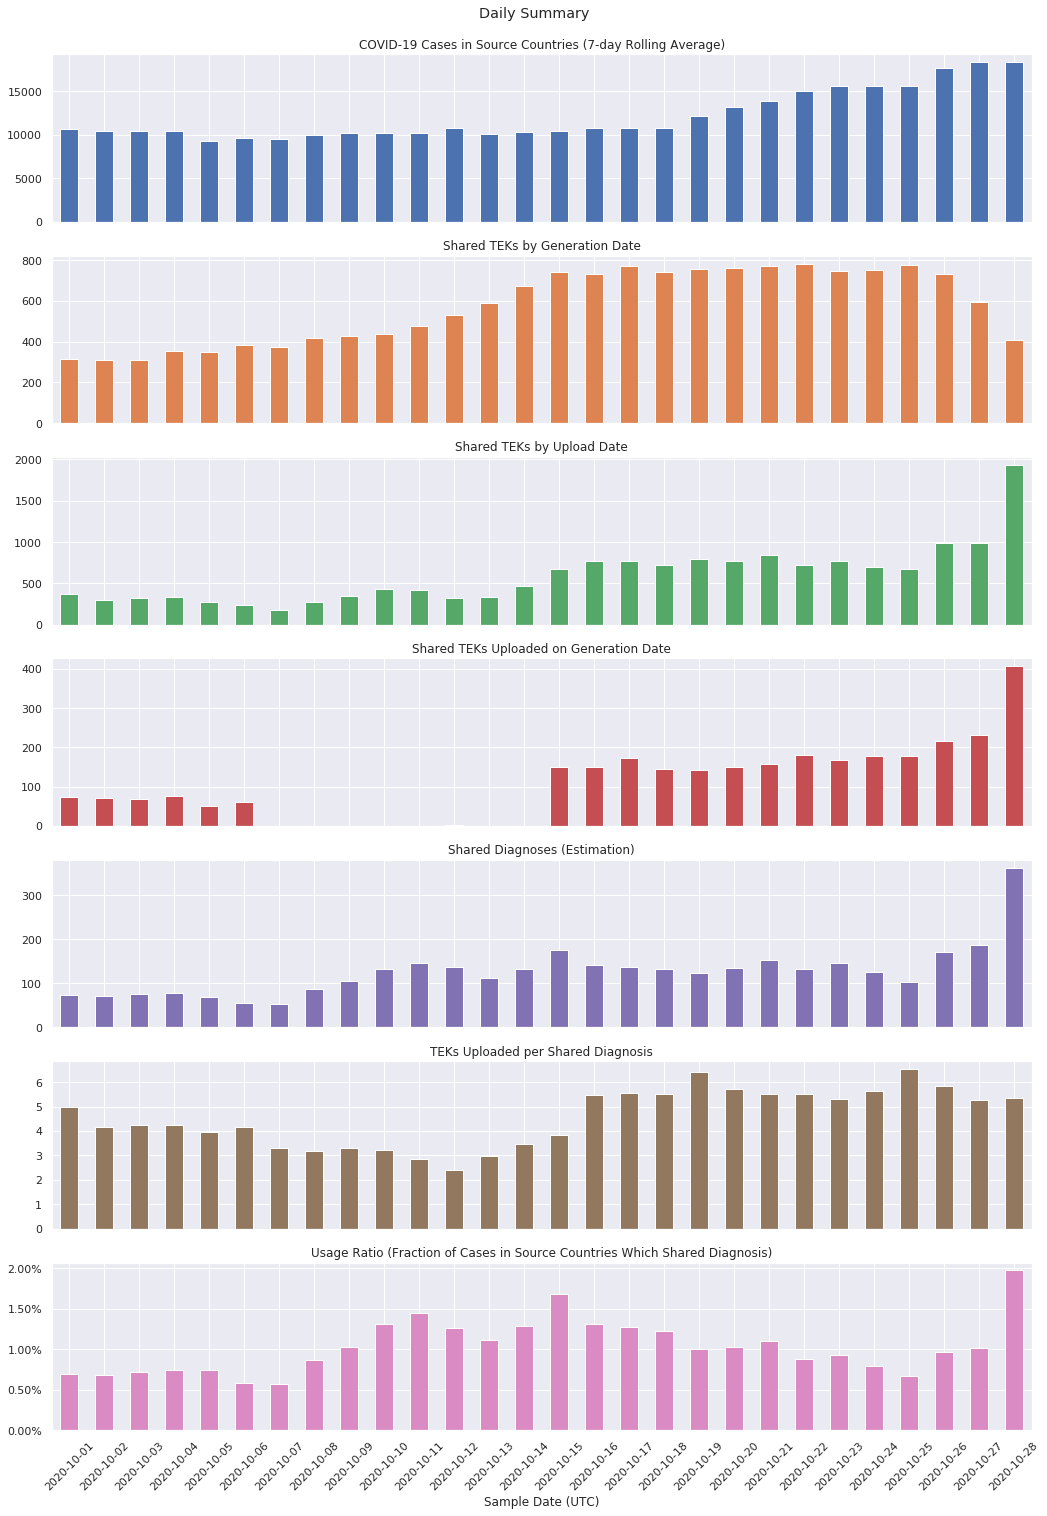

In [52]:
result_plot_summary_df = result_summary_df.head(daily_plot_days)[summary_columns] \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping)
summary_ax_list = result_plot_summary_df.sort_index(ascending=True).plot.bar(
    title=f"Daily Summary",
    rot=45, subplots=True, figsize=(15, 22), legend=False)
ax_ = summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.95)
ax_.yaxis.set_major_formatter(matplotlib.ticker.PercentFormatter(1.0))
_ = ax_.set_xticklabels(sorted(result_plot_summary_df.index.strftime("%Y-%m-%d").tolist()))

### Daily Generation to Upload Period Table

In [53]:
display_generation_to_upload_period_pivot_df = \
    generation_to_upload_period_pivot_df \
        .head(backend_generation_days)
display_generation_to_upload_period_pivot_df \
    .head(backend_generation_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping)

Generation to Upload Period in Days,0,1,2,3,4,5,6,7,8,9,10,11,12,13
Upload Date (UTC),,,,,,,,,,,,,,
2020-10-28,406,362,328,263,204,138,88,62,35,17,10,7,7,6
2020-10-27,231,187,164,123,98,77,44,28,22,11,3,0,0,0
2020-10-26,215,170,145,124,105,85,51,32,24,18,12,6,5,2
2020-10-25,179,104,95,82,71,55,37,25,15,8,5,2,1,0
2020-10-24,177,125,106,89,69,50,28,19,12,10,6,5,5,2
2020-10-23,167,145,129,106,85,58,29,19,14,9,3,3,1,1
2020-10-22,180,132,114,100,76,51,26,18,10,6,4,4,3,2
2020-10-21,157,153,136,120,97,62,34,28,20,15,9,4,3,3
2020-10-20,149,135,119,106,79,59,47,25,21,13,8,6,3,2


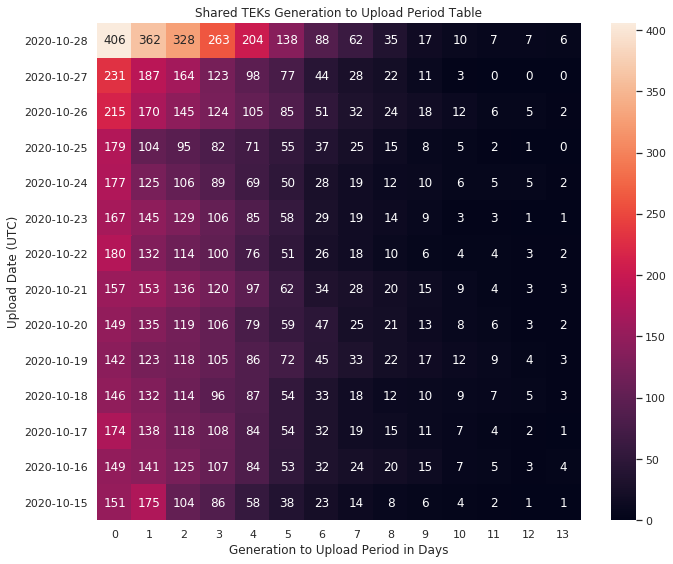

In [54]:
fig, generation_to_upload_period_pivot_table_ax = plt.subplots(
    figsize=(10, 1 + 0.5 * len(display_generation_to_upload_period_pivot_df)))
generation_to_upload_period_pivot_table_ax.set_title(
    "Shared TEKs Generation to Upload Period Table")
sns.heatmap(
    data=display_generation_to_upload_period_pivot_df
        .rename_axis(columns=display_column_name_mapping)
        .rename_axis(index=display_column_name_mapping),
    fmt=".0f",
    annot=True,
    ax=generation_to_upload_period_pivot_table_ax)
generation_to_upload_period_pivot_table_ax.get_figure().tight_layout()

### Hourly Summary Plots 

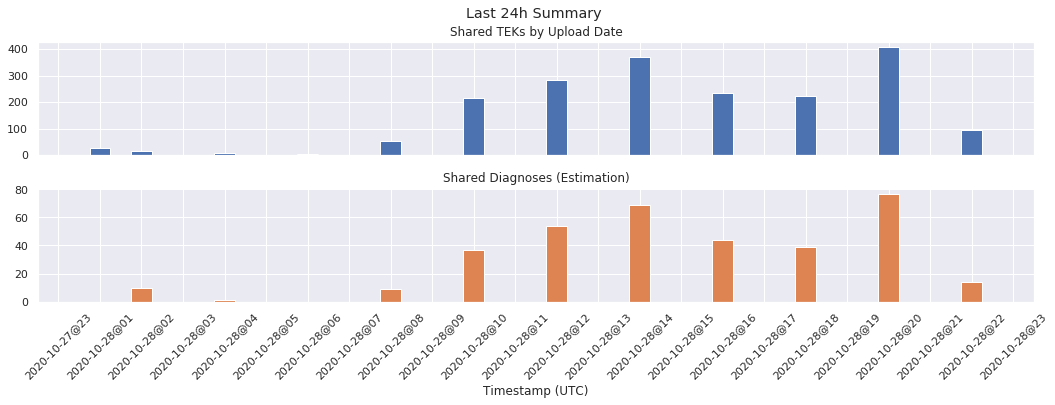

In [55]:
hourly_summary_ax_list = hourly_summary_df \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .plot.bar(
        title=f"Last 24h Summary",
        rot=45, subplots=True, legend=False)
ax_ = hourly_summary_ax_list[-1]
ax_.get_figure().tight_layout()
ax_.get_figure().subplots_adjust(top=0.9)
_ = ax_.set_xticklabels(sorted(hourly_summary_df.index.strftime("%Y-%m-%d@%H").tolist()))

### Publish Results

In [56]:
def get_temporary_image_path() -> str:
    return os.path.join(tempfile.gettempdir(), str(uuid.uuid4()) + ".png")

def save_temporary_plot_image(ax):
    if isinstance(ax, np.ndarray):
        ax = ax[0]
    media_path = get_temporary_image_path()
    ax.get_figure().savefig(media_path)
    return media_path

def save_temporary_dataframe_image(df):
    import dataframe_image as dfi
    media_path = get_temporary_image_path()
    dfi.export(df, media_path)
    return media_path

In [57]:
github_repository = os.environ.get("GITHUB_REPOSITORY")
if github_repository is None:
    github_repository = "pvieito/Radar-STATS"

github_project_base_url = "https://github.com/" + github_repository

display_formatters = {
    display_column_name_mapping["teks_per_shared_diagnosis"]: lambda x: f"{x:.2f}",
    display_column_name_mapping["shared_diagnoses_per_covid_case"]: lambda x: f"{x:.2%}",
}
daily_summary_table_html = result_summary_with_display_names_df \
    .head(daily_plot_days) \
    .rename_axis(index=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .to_html(formatters=display_formatters)
multi_backend_summary_table_html = multi_backend_summary_df \
    .head(daily_plot_days) \
    .rename_axis(columns=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping) \
    .to_html(formatters=display_formatters)

def format_multi_backend_cross_sharing_fraction(x):
    if pd.isna(x):
        return "-"
    elif round(x * 100, 1) == 0:
        return ""
    else:
        return f"{x:.1%}"

multi_backend_cross_sharing_summary_table_html = multi_backend_cross_sharing_summary_df \
    .rename_axis(columns=display_column_name_mapping) \
    .rename(columns=display_column_name_mapping) \
    .rename_axis(index=display_column_name_mapping) \
    .to_html(
        classes="table-center",
        formatters=display_formatters,
        float_format=format_multi_backend_cross_sharing_fraction)
multi_backend_cross_sharing_summary_table_html = \
    multi_backend_cross_sharing_summary_table_html \
        .replace("<tr>","<tr style=\"text-align: center;\">")

extraction_date_result_summary_df = \
    result_summary_df[result_summary_df.index == extraction_date]
extraction_date_result_hourly_summary_df = \
    hourly_summary_df[hourly_summary_df.extraction_date_with_hour == extraction_date_with_hour]

covid_cases = \
    extraction_date_result_summary_df.covid_cases.sum()
shared_teks_by_generation_date = \
    extraction_date_result_summary_df.shared_teks_by_generation_date.sum()
shared_teks_by_upload_date = \
    extraction_date_result_summary_df.shared_teks_by_upload_date.sum()
shared_diagnoses = \
    extraction_date_result_summary_df.shared_diagnoses.sum()
teks_per_shared_diagnosis = \
    extraction_date_result_summary_df.teks_per_shared_diagnosis.sum()
shared_diagnoses_per_covid_case = \
    extraction_date_result_summary_df.shared_diagnoses_per_covid_case.sum()

shared_teks_by_upload_date_last_hour = \
    extraction_date_result_hourly_summary_df.shared_teks_by_upload_date.sum().astype(int)
shared_diagnoses_last_hour = \
    extraction_date_result_hourly_summary_df.shared_diagnoses.sum().astype(int)

display_source_regions = ", ".join(report_source_regions)

display_brief_source_regions_limit = 2
if len(report_source_regions) <= display_brief_source_regions_limit:
    display_brief_source_regions = display_source_regions
else:
    prefix_countries = ", ".join(report_source_regions[:display_brief_source_regions_limit])
    display_brief_source_regions = f"{len(report_source_regions)} ({prefix_countries}…)"

In [58]:
summary_plots_image_path = save_temporary_plot_image(
    ax=summary_ax_list)
summary_table_image_path = save_temporary_dataframe_image(
    df=result_summary_with_display_names_df)
hourly_summary_plots_image_path = save_temporary_plot_image(
    ax=hourly_summary_ax_list)
multi_backend_summary_table_image_path = save_temporary_dataframe_image(
    df=multi_backend_summary_df)
generation_to_upload_period_pivot_table_image_path = save_temporary_plot_image(
    ax=generation_to_upload_period_pivot_table_ax)

### Save Results

In [59]:
report_resources_path_prefix = "Data/Resources/Current/RadarCOVID-Report-"
result_summary_df.to_csv(
    report_resources_path_prefix + "Summary-Table.csv")
result_summary_df.to_html(
    report_resources_path_prefix + "Summary-Table.html")
hourly_summary_df.to_csv(
    report_resources_path_prefix + "Hourly-Summary-Table.csv")
multi_backend_summary_df.to_csv(
    report_resources_path_prefix + "Multi-Backend-Summary-Table.csv")
multi_backend_cross_sharing_summary_df.to_csv(
    report_resources_path_prefix + "Multi-Backend-Cross-Sharing-Summary-Table.csv")
generation_to_upload_period_pivot_df.to_csv(
    report_resources_path_prefix + "Generation-Upload-Period-Table.csv")
_ = shutil.copyfile(
    summary_plots_image_path,
    report_resources_path_prefix + "Summary-Plots.png")
_ = shutil.copyfile(
    summary_table_image_path,
    report_resources_path_prefix + "Summary-Table.png")
_ = shutil.copyfile(
    hourly_summary_plots_image_path,
    report_resources_path_prefix + "Hourly-Summary-Plots.png")
_ = shutil.copyfile(
    multi_backend_summary_table_image_path,
    report_resources_path_prefix + "Multi-Backend-Summary-Table.png")
_ = shutil.copyfile(
    generation_to_upload_period_pivot_table_image_path,
    report_resources_path_prefix + "Generation-Upload-Period-Table.png")

### Publish Results as JSON

In [60]:
summary_results_api_df = result_summary_df.reset_index()
summary_results_api_df["sample_date_string"] = \
    summary_results_api_df["sample_date"].dt.strftime("%Y-%m-%d")

summary_results = dict(
    source_regions=report_source_regions,
    extraction_datetime=extraction_datetime,
    extraction_date=extraction_date,
    extraction_date_with_hour=extraction_date_with_hour,
    last_hour=dict(
        shared_teks_by_upload_date=shared_teks_by_upload_date_last_hour,
        shared_diagnoses=shared_diagnoses_last_hour,
    ),
    today=dict(
        covid_cases=covid_cases,
        shared_teks_by_generation_date=shared_teks_by_generation_date,
        shared_teks_by_upload_date=shared_teks_by_upload_date,
        shared_diagnoses=shared_diagnoses,
        teks_per_shared_diagnosis=teks_per_shared_diagnosis,
        shared_diagnoses_per_covid_case=shared_diagnoses_per_covid_case,
    ),
    last_7_days=last_7_days_summary,
    daily_results=summary_results_api_df.to_dict(orient="records"))
summary_results = \
    json.loads(pd.Series([summary_results]).to_json(orient="records"))[0]

with open(report_resources_path_prefix + "Summary-Results.json", "w") as f:
    json.dump(summary_results, f, indent=4)

### Publish on README

In [61]:
with open("Data/Templates/README.md", "r") as f:
    readme_contents = f.read()

readme_contents = readme_contents.format(
    extraction_date_with_hour=extraction_date_with_hour,
    github_project_base_url=github_project_base_url,
    daily_summary_table_html=daily_summary_table_html,
    multi_backend_summary_table_html=multi_backend_summary_table_html,
    multi_backend_cross_sharing_summary_table_html=multi_backend_cross_sharing_summary_table_html,
    display_source_regions=display_source_regions)

with open("README.md", "w") as f:
    f.write(readme_contents)

### Publish on Twitter

In [62]:
enable_share_to_twitter = os.environ.get("RADARCOVID_REPORT__ENABLE_PUBLISH_ON_TWITTER")
github_event_name = os.environ.get("GITHUB_EVENT_NAME")

if enable_share_to_twitter and github_event_name == "schedule" and \
        (shared_teks_by_upload_date_last_hour or not are_today_results_partial):
    import tweepy

    twitter_api_auth_keys = os.environ["RADARCOVID_REPORT__TWITTER_API_AUTH_KEYS"]
    twitter_api_auth_keys = twitter_api_auth_keys.split(":")
    auth = tweepy.OAuthHandler(twitter_api_auth_keys[0], twitter_api_auth_keys[1])
    auth.set_access_token(twitter_api_auth_keys[2], twitter_api_auth_keys[3])

    api = tweepy.API(auth)

    summary_plots_media = api.media_upload(summary_plots_image_path)
    summary_table_media = api.media_upload(summary_table_image_path)
    generation_to_upload_period_pivot_table_image_media = api.media_upload(generation_to_upload_period_pivot_table_image_path)
    media_ids = [
        summary_plots_media.media_id,
        summary_table_media.media_id,
        generation_to_upload_period_pivot_table_image_media.media_id,
    ]

    if are_today_results_partial:
        today_addendum = " (Partial)"
    else:
        today_addendum = ""

    status = textwrap.dedent(f"""
        #RadarCOVID – {extraction_date_with_hour}

        Countries: {display_brief_source_regions}

        Today{today_addendum}:
        - Uploaded TEKs: {shared_teks_by_upload_date:.0f} ({shared_teks_by_upload_date_last_hour:+d} last hour)
        - Shared Diagnoses: ≤{shared_diagnoses:.0f} ({shared_diagnoses_last_hour:+d} last hour)
        - Usage Ratio: ≤{shared_diagnoses_per_covid_case:.2%}

        Last 7 Days:
        - Shared Diagnoses: ≤{last_7_days_summary["shared_diagnoses"]:.0f}
        - Usage Ratio: ≤{last_7_days_summary["shared_diagnoses_per_covid_case"]:.2%}

        Info: {github_project_base_url}#documentation
        """)
    status = status.encode(encoding="utf-8")
    api.update_status(status=status, media_ids=media_ids)